# **6. Feature Engineering**

Feature engineering ini bertujuan menyiapkan data input yang optimal untuk proses modeling klasifikasi kategori AQI (Air Quality Index).

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

In [12]:
# Load dataset
df = pd.read_csv('/content/air_quality_data_clean.csv')

# Tampilkan 5 baris pertama dari dataset
print("Dataset Air Quality:")
display(df.head())

Dataset Air Quality:


,date,pm25,pm10,o3,no2,loc,aqi,so2,co,year,month,day,country,yearmonth,aqi_category
0,2013/12/31,162.444444,68.0,4,9,los-angeles-north main street,57,1.0,17.0,2013.0,12.0,31.0,united states,13-Dec,Moderate
1,2013/12/31,52.555556,22.0,31,6,"oyama,-niigata, japan",20,6.0,3.0,2013.0,12.0,31.0,japan,13-Dec,Good
2,2013/12/31,38.222222,16.0,13,23,"london-marylebone road, united kingdom",15,7.0,5.0,2013.0,12.0,31.0,united kingdom,13-Dec,Good
3,2013/12/31,31.055556,13.0,24,7,"london-westminster, united kingdom",4,3.0,3.0,2013.0,12.0,31.0,united kingdom,13-Dec,Good
4,2013/12/31,31.055556,13.0,24,3,"seindl,-dissay-weg, austria",2,3.0,3.0,2013.0,12.0,31.0,austria,13-Dec,Good


### Langkah Feature Engineering yang Dilakukan

**1. Konversi Kolom `date` ke datetime**  
Mengubah kolom `date` menjadi tipe data `datetime` agar dapat digunakan untuk ekstraksi fitur waktu secara mudah dan tepat.

**2. Penanganan Outlier pada Polutan**  
Melakukan *clipping* nilai outlier pada fitur polutan utama (`pm25`, `pm10`, `o3`, `no2`, `so2`, `co`) ke dalam rentang **kuantil ke-1 (1%) hingga kuantil ke-99 (99%)**.  
Tujuan clipping adalah untuk mengurangi pengaruh nilai ekstrem tanpa menghilangkan data, sehingga distribusi data menjadi lebih stabil.

**3. Ekstraksi Fitur Waktu**  
- `dayofweek`: nomor hari dalam seminggu (0 = Senin, ..., 6 = Minggu).  
- `is_weekend`: fitur biner indikator akhir pekan, bernilai 1 jika hari Sabtu atau Minggu, 0 jika hari kerja.

**4. Fitur Kombinasi Polutan**  
- `total_pollutants`: jumlah total semua polutan utama per baris, sebagai indikator akumulasi pencemaran udara.  
- `pm25_pm10_ratio`: rasio `pm25` terhadap `pm10` yang menggambarkan perbandingan ukuran partikel polutan; nilai 0 jika `pm10` bernilai 0 untuk menghindari pembagian nol.

**5. Encoding Fitur Kategorikal dengan Label Encoding yang Aman**  
Melakukan Label Encoding pada fitur kategorikal:  
- `country` → `country_encoded`  
- `loc` → `loc_encoded`  
- `aqi_category` → `aqi_cat_encoded`  

Label Encoding dilakukan secara aman, yaitu jika ada label baru yang tidak dikenali saat transformasi, maka akan diberikan nilai -1. Ini menjaga konsistensi encoding saat penerapan model di data baru (inference).

**6. Persiapan Target Klasifikasi**  
Kolom `target` adalah hasil encoding dari `aqi_category` (`aqi_cat_encoded`), yang akan digunakan sebagai label output pada model klasifikasi.

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def safe_label_transform(series, label_encoder):
    """Transformasi label yang aman, unknown label jadi -1."""
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return series.map(mapping).fillna(-1).astype(int)

def base_feature_engineering(df, verbose=True,
                             le_country=None, le_loc=None, le_cat=None,
                             fit_encoder=True):
    df = df.copy()

    # 1. Konversi tanggal
    df['date'] = pd.to_datetime(df['date'])
    if verbose:
        print("✅ Konversi date ke datetime selesai. Contoh:")
        print(df[['date']].head())

    # 2. Clipping outlier polutan
    pollutant_cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
    for col in pollutant_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    if verbose:
        print("\n✅ Outlier pada kolom polutan sudah di-clipping ke rentang 1%-99% quantile.")

    # 3. Ekstraksi waktu
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    if verbose:
        print("\n✅ Fitur waktu ditambahkan: dayofweek & is_weekend.")

    # 4. Fitur tambahan
    df['total_pollutants'] = df[pollutant_cols].sum(axis=1)
    df['pm25_pm10_ratio'] = np.where(df['pm10'] != 0, df['pm25'] / df['pm10'], 0)
    if verbose:
        print("\n✅ Fitur total_pollutants & rasio pm25/pm10 selesai.")

    # 5. Encoding kategori
    if fit_encoder or le_country is None:
        le_country = LabelEncoder().fit(df['country'])
    df['country_encoded'] = safe_label_transform(df['country'], le_country)

    if fit_encoder or le_loc is None:
        le_loc = LabelEncoder().fit(df['loc'])
    df['loc_encoded'] = safe_label_transform(df['loc'], le_loc)

    if fit_encoder or le_cat is None:
        le_cat = LabelEncoder().fit(df['aqi_category'])
    df['aqi_cat_encoded'] = safe_label_transform(df['aqi_category'], le_cat)

    df['target'] = df['aqi_cat_encoded']

    if verbose:
        print("\n✅ Label encoding selesai. Contoh:")
        print(df[['country', 'country_encoded', 'aqi_category', 'target']].head())

    # Return juga encoder agar bisa disimpan
    return df, le_country, le_loc, le_cat

---

### Persiapan Dataset untuk Model

**Untuk Model Tree-Based (misal Random Forest, XGBoost):**  
Gunakan fitur numerik yang telah melalui label encoding. Tidak diperlukan one-hot encoding atau scaling.

**Untuk Model Linear (misal Logistic Regression, SVM):**  
- Dilakukan **one-hot encoding** pada fitur kategorikal seperti `country` dan `aqi_category`.  
- Dilakukan **standardisasi** pada fitur numerik menggunakan `StandardScaler` untuk menyamakan skala data.

---

In [14]:
def prepare_for_tree_models(df_fe):
    cols_to_use = [
        'pm25', 'pm10', 'o3', 'no2', 'so2', 'co',
        'dayofweek', 'is_weekend',
        'total_pollutants', 'pm25_pm10_ratio',
        'country_encoded', 'loc_encoded'
    ]
    return df_fe[cols_to_use]

In [15]:
def prepare_for_linear_models(df_fe, preprocessor=None, fit=True):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer

    # Kolom kategorikal dan numerik
    categorical_cols = ['country', 'loc']
    numerical_cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co',
                      'total_pollutants', 'pm25_pm10_ratio', 'dayofweek', 'is_weekend']

    # Drop kolom yang tidak digunakan
    df_cleaned = df_fe.drop(columns=['aqi_category', 'target',
                                     'country_encoded', 'loc_encoded', 'aqi_cat_encoded', 'date'])

    if fit or preprocessor is None:
        preprocessor = ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', StandardScaler(), numerical_cols)
        ])
        X_processed = preprocessor.fit_transform(df_cleaned).toarray()
    else:
        X_processed = preprocessor.transform(df_cleaned)

    return X_processed, preprocessor

### Label AQI dan Representasi Encoding

| Label AQI                          | Label Encoded (Target) |
|-----------------------------------|-------------------------|
| Good                              | 0                       |
| Moderate                          | 1                       |
| Unhealthy for Sensitive Groups    | 2                       |
| Unhealthy                         | 3                       |
| Very Unhealthy                    | 4                       |
| Hazardous                         | 5                       |

# **7. Modeling**

## Model Development

**1️⃣Tree Based Model (Decision Tree - Random Forest - XGBoost)**

**2️⃣Linear Model (Logistic Regression - SVM)**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# ==== Step 1: Feature Engineering ====
(df_fe, le_country, le_loc, le_cat) = base_feature_engineering(df)
y = df_fe['target']

✅ Konversi date ke datetime selesai. Contoh:
        date
0 2013-12-31
1 2013-12-31
2 2013-12-31
3 2013-12-31
4 2013-12-31

✅ Outlier pada kolom polutan sudah di-clipping ke rentang 1%-99% quantile.

✅ Fitur waktu ditambahkan: dayofweek & is_weekend.

✅ Fitur total_pollutants & rasio pm25/pm10 selesai.

✅ Label encoding selesai. Contoh:
          country  country_encoded aqi_category  target
0   united states               27     Moderate       2
1           japan               17         Good       0
2  united kingdom               26         Good       0
3  united kingdom               26         Good       0
4         austria                3         Good       0


In [17]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265590 entries, 0 to 265589
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              265590 non-null  datetime64[ns]
 1   pm25              265590 non-null  float64       
 2   pm10              265590 non-null  float64       
 3   o3                265590 non-null  int64         
 4   no2               265590 non-null  int64         
 5   loc               265590 non-null  object        
 6   aqi               265590 non-null  int64         
 7   so2               265589 non-null  float64       
 8   co                265589 non-null  float64       
 9   year              265589 non-null  float64       
 10  month             265589 non-null  float64       
 11  day               265589 non-null  float64       
 12  country           265589 non-null  object        
 13  yearmonth         265589 non-null  object        
 14  aqi_

In [18]:
# ==== Step 2: Persiapan data ====
X_tree = prepare_for_tree_models(df_fe)
X_linear, preprocessor = prepare_for_linear_models(df_fe)

## Data Splitting

**Train: 60%, Validation: 20%, Test: 20%**

In [26]:
# ==== Step 3: Split data 60% train, 20% val, 20% test ====
class_counts = pd.Series(y).value_counts()
classes_to_keep = class_counts[class_counts >= 2].index

mask = pd.Series(y).isin(classes_to_keep)

X_tree_filtered = X_tree[mask]
X_linear_filtered = X_linear[mask]
y_filtered = y[mask]

# Tree model split
X_tree_train, X_tree_temp, y_train_tree, y_temp_tree = train_test_split(
    X_tree_filtered, y_filtered, test_size=0.4, random_state=42, stratify=y_filtered)

X_tree_val, X_tree_test, y_val_tree, y_test_tree = train_test_split(
    X_tree_temp, y_temp_tree, test_size=0.5, random_state=42, stratify=y_temp_tree)

# Linear model split
X_lin_train, X_lin_temp, y_train_lin, y_temp_lin = train_test_split(
    X_linear_filtered, y_filtered, test_size=0.4, random_state=42, stratify=y_filtered)

X_lin_val, X_lin_test, y_val_lin, y_test_lin = train_test_split(
    X_lin_temp, y_temp_lin, test_size=0.5, random_state=42, stratify=y_temp_lin)

In [27]:
# Untuk tree model
print(f"Train size (tree): {X_tree_train.shape[0]}")
print(f"Validation size (tree): {X_tree_val.shape[0]}")
print(f"Test size (tree): {X_tree_test.shape[0]}")
# Untuk linear model
print(f"Train size (linear): {X_lin_train.shape[0]}")
print(f"Validation size (linear): {X_lin_val.shape[0]}")
print(f"Test size (linear): {X_lin_test.shape[0]}")

Train size (tree): 159353
Validation size (tree): 53118
Test size (tree): 53118
Train size (linear): 159353
Validation size (linear): 53118
Test size (linear): 53118


### Baseline Model (Decision Tree)

In [28]:
# ==== Step 5: Inisialisasi model Baseline ====
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Baseline model dengan Decision Tree
tree_baseline = DecisionTreeClassifier(random_state=42)
tree_baseline.fit(X_tree_train, y_train_tree)

# Prediksi di validation set
y_val_pred = tree_baseline.predict(X_tree_val)

# Evaluasi di validation set
print("📊 Baseline Decision Tree - Validation Set")
print(classification_report(y_val_tree, y_val_pred))

📊 Baseline Decision Tree - Validation Set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11835
           1       0.65      0.69      0.67       146
           2       1.00      1.00      1.00     15300
           3       1.00      1.00      1.00     12862
           4       1.00      1.00      1.00     11588
           5       0.96      0.95      0.95      1387

    accuracy                           0.99     53118
   macro avg       0.93      0.94      0.93     53118
weighted avg       0.99      0.99      0.99     53118



## Model Comparison

Random Forest, XGBoost, Logistic Regression, and SVM

In [29]:
# ==== Step 6: Model Comparison ====
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

In [30]:
# ==== Step 7: Evaluasi model ====
print("📊 Classification Report pada Validation Set:\n")

for name, model in models.items():
    # Gunakan dataset sesuai tipe model
    if "Forest" in name or "XGB" in name:
        X_train, y_train = X_tree_train, y_train_tree
        X_val, y_val = X_tree_val, y_val_tree
    else:
        X_train, y_train = X_lin_train, y_train_lin
        X_val, y_val = X_lin_val, y_val_lin

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    print(f"✅ {name} Classification Report:")
    print(classification_report(y_val, preds))
    print("-" * 60)

📊 Classification Report pada Validation Set:

✅ Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     11835
           1       0.78      0.62      0.69       146
           2       1.00      1.00      1.00     15300
           3       1.00      1.00      1.00     12862
           4       1.00      1.00      1.00     11588
           5       0.94      0.98      0.96      1387

    accuracy                           1.00     53118
   macro avg       0.95      0.93      0.94     53118
weighted avg       1.00      1.00      1.00     53118

------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:26:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11835
           1       0.73      0.66      0.70       146
           2       1.00      1.00      1.00     15300
           3       1.00      1.00      1.00     12862
           4       1.00      1.00      1.00     11588
           5       0.95      0.97      0.96      1387

    accuracy                           1.00     53118
   macro avg       0.95      0.94      0.94     53118
weighted avg       1.00      1.00      1.00     53118

------------------------------------------------------------
✅ Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11835
           1       0.89      0.56      0.69       146
           2       0.87      0.89      0.88     15300
           3       0.90      0.88      0.89     12862
           4       0.79      0.78      0.79    

## Hyperparameter Tunning (Linear Regression)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Pipeline akhir untuk Logistic Regression dengan hyperparameter tuning
logreg_pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [32]:
# Parameter grid untuk GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced']
}

In [33]:
# GridSearchCV dengan 3-fold CV, scoring akurasi, verbose dan paralelisasi
grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [34]:
# Fit ke data hasil prepare_for_linear_models
grid_search.fit(X_lin_train, y_train_lin)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l2']},
             scoring='accuracy', verbose=2)

In [35]:
# Evaluasi pada validation set
print("Best Parameters:", grid_search.best_params_)
y_pred_val = grid_search.predict(X_lin_val)
print(classification_report(y_val_lin, y_pred_val))

Best Parameters: {'clf__C': 100, 'clf__class_weight': None, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11835
           1       0.87      0.58      0.70       146
           2       0.87      0.90      0.88     15300
           3       0.90      0.88      0.89     12862
           4       0.80      0.79      0.79     11588
           5       0.87      0.89      0.88      1387

    accuracy                           0.86     53118
   macro avg       0.86      0.82      0.84     53118
weighted avg       0.86      0.86      0.86     53118



## Cross-validation & Performance Metrics

In [36]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score

# Skor yang ingin dievaluasi
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

In [37]:
# Data untuk tiap model
model_data = {
    "Decision Tree": (DecisionTreeClassifier(random_state=42), X_tree_train, y_train_tree),
    "Random Forest": (RandomForestClassifier(random_state=42), X_tree_train, y_train_tree),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), X_tree_train, y_train_tree),
    "Logistic Regression": (LogisticRegression(C=10, class_weight='balanced', penalty='l2', max_iter=1000, random_state=42), X_lin_train, y_train_lin),
    "SVM": (SVC(), X_lin_train, y_train_lin)
}

In [38]:
results = {}

print("🔁 Cross-validation Results:\n")
for name, (model, X, y) in model_data.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring, n_jobs=-1)
    results[name] = scores
    print(f"📌 {name}")
    for metric in scoring.keys():
        mean = scores[f'test_{metric}'].mean()
        std = scores[f'test_{metric}'].std()
        print(f"{metric:<15}: {mean:.4f} ± {std:.4f}")
    print("-" * 50)

🔁 Cross-validation Results:

📌 Decision Tree
accuracy       : 0.9941 ± 0.0003
f1_macro       : 0.9229 ± 0.0047
precision_macro: 0.9213 ± 0.0073
recall_macro   : 0.9256 ± 0.0075
--------------------------------------------------
📌 Random Forest
accuracy       : 0.9957 ± 0.0004
f1_macro       : 0.9363 ± 0.0075
precision_macro: 0.9556 ± 0.0082
recall_macro   : 0.9240 ± 0.0097
--------------------------------------------------
📌 XGBoost
accuracy       : 0.9970 ± 0.0003
f1_macro       : 0.9375 ± 0.0072
precision_macro: 0.9479 ± 0.0057
recall_macro   : 0.9300 ± 0.0108
--------------------------------------------------
📌 Logistic Regression
accuracy       : 0.8546 ± 0.0033
f1_macro       : 0.7738 ± 0.0066
precision_macro: 0.7392 ± 0.0069
recall_macro   : 0.8502 ± 0.0089
--------------------------------------------------
📌 SVM
accuracy       : 0.9687 ± 0.0008
f1_macro       : 0.8959 ± 0.0108
precision_macro: 0.9566 ± 0.0064
recall_macro   : 0.8742 ± 0.0102
-------------------------------------

Berdasarkan hasil **cross-validation** dengan metrik utama (accuracy, f1_macro, precision_macro, recall_macro), **XGBoost** merupakan model terbaik dengan performa tertinggi pada semua metrik utama.

## Final Model Selection & Refinement

**Hyperparameter Tuning dengan RandomizedSearchCV**

In [39]:
from sklearn.model_selection import RandomizedSearchCV

# Inisialisasi model dasar
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [40]:
# Parameter grid untuk tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [41]:
# Randomized Search dengan 3-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [42]:
# Fit ke training set
random_search.fit(X_tree_train, y_train_tree)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:58:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [43]:
# Hasil parameter terbaik
print("🔍 Best Parameters:", random_search.best_params_)

🔍 Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


**Evaluasi Final di Test Set**

In [44]:
# Model terbaik dari hasil tuning
best_xgb = random_search.best_estimator_

# Prediksi pada test set
y_test_pred = best_xgb.predict(X_tree_test)

# Evaluasi performa akhir
print("📊 Final Evaluation on Test Set:")
print(classification_report(y_test_tree, y_test_pred))
print("✅ Accuracy:", accuracy_score(y_test_tree, y_test_pred))
print("✅ F1 Macro:", f1_score(y_test_tree, y_test_pred, average='macro'))

📊 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11835
           1       0.74      0.63      0.68       147
           2       1.00      1.00      1.00     15299
           3       1.00      1.00      1.00     12863
           4       1.00      1.00      1.00     11587
           5       0.95      0.98      0.96      1387

    accuracy                           1.00     53118
   macro avg       0.95      0.93      0.94     53118
weighted avg       1.00      1.00      1.00     53118

✅ Accuracy: 0.9972325765277307
✅ F1 Macro: 0.940315409135066


In [45]:
# Save Encoder
import pickle

# Simpan encoder ke file
with open('le_country.pkl', 'wb') as f:
    pickle.dump(le_country, f)

with open('le_loc.pkl', 'wb') as f:
    pickle.dump(le_loc, f)

with open('le_cat.pkl', 'wb') as f:
    pickle.dump(le_cat, f)

In [46]:
# Simpan model XGBoost terbaik
with open('xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

**Error Analysis**

Confusion Matrix:
[[11819     3     4     6     3     0]
 [    0    93     0     0     0    54]
 [   11     2 15273     1     0    12]
 [    7     0     0 12856     0     0]
 [    7     1     3     0 11575     1]
 [    0    27     3     1     1  1355]]


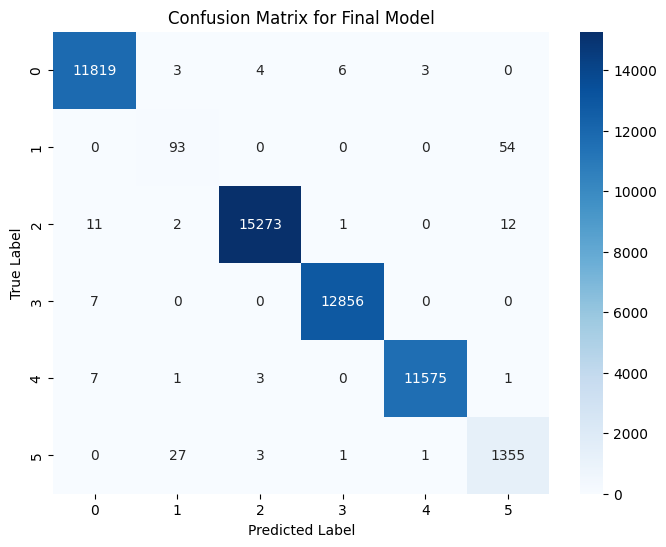

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada test set (misal menggunakan best_xgb yang sudah dituning)
y_test_pred = best_xgb.predict(X_tree_test)

# Buat confusion matrix
cm = confusion_matrix(y_test_tree, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_xgb.classes_, yticklabels=best_xgb.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Model")
plt.show()

**Feature Importance**

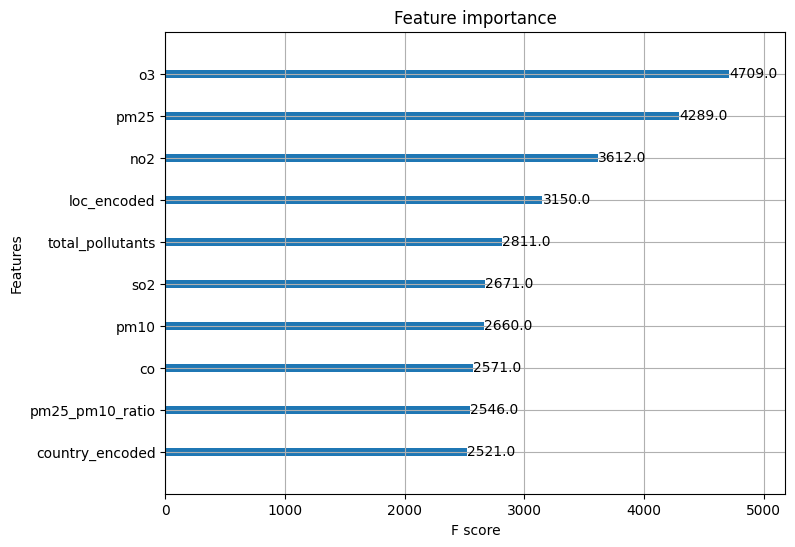

In [48]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance (top 10)
fig, ax = plt.subplots(figsize=(8,6))
plot_importance(best_xgb, max_num_features=10, ax=ax)

# Simpan gambar ke file
plt.savefig('feature_importance_top10.png', dpi=300, bbox_inches='tight')
plt.show()

# 📊 Feature Importance Analysis
| Fitur             | Skor F   | Insight                                                                                  |
|-------------------|----------|------------------------------------------------------------------------------------------------|
| o3              | 4,709    | Kontributor tertinggi, ozon merupakan indikator kunci dalam penentuan kategori AQI.     |
| pm25            | 4,289    | PM2.5 sangat penting sebagai salah satu polutan utama yang mempengaruhi kualitas udara. |
| no2             | 3,612    | NO2 sebagai polutan gas memiliki pengaruh cukup signifikan terhadap kategori AQI.            |
| loc_encoded     | 3,150    | Lokasi geografis berperan penting, menunjukkan variasi polusi antar daerah.            |
| total_pollutants| 2,811    | Jumlah total polutan memberikan gambaran umum tingkat pencemaran udara.                |
| so2             | 2,671    | SO2 cukup berkontribusi dalam menentukan kategori AQI.                         |
| pm10            | 2,660    | PM10 juga cukup berpengaruh, meski sedikit di bawah PM2.5.                      |
| co              | 2,571    | Karbon monoksida memberikan kontribusi yang relatif lebih rendah.                      |

---
**Catatan:**  
Analisis ini memberikan gambaran fitur mana yang paling berpengaruh dalam menentukan kategori AQI berdasarkan skor F pada model prediksi.
Ozon (O3) dan PM2.5 menjadi fitur paling dominan dalam prediksi kategori AQI, sejalan dengan standar internasional kualitas udara yang memprioritaskan kedua polutan ini sebagai indikator utama.

## Inference

In [49]:
import pandas as pd

# ✅ 1. Data baru untuk diprediksi
new_data = pd.DataFrame([{
    'date': '2025-05-21',
    'pm25': 60,
    'pm10': 90,
    'o3': 35,
    'no2': 45,
    'so2': 15,
    'co': 0.7,
    'country': 'Indonesia',
    'loc': 'Jakarta',
    'aqi_category': 'Moderate'  # Dummy untuk melewati preprocessing, nanti tidak dipakai
}])

# ✅ 2. Lakukan feature engineering (menggunakan fungsi sebelumnya)
# Pakai encoder yang sudah dilatih: le_country, le_loc, le_cat
df_fe, _, _, _ = base_feature_engineering(
    new_data,
    verbose=False,
    le_country=le_country,
    le_loc=le_loc,
    le_cat=le_cat,
    fit_encoder=False
)

# ✅ 3. Siapkan data input untuk tree model
X_infer = prepare_for_tree_models(df_fe)

# ✅ 4. Inference dengan model hasil tuning
pred_encoded = best_xgb.predict(X_infer)[0]
pred_label = le_cat.inverse_transform([pred_encoded])[0]
pred_proba = best_xgb.predict_proba(X_infer)[0]

# ✅ 5. Tampilkan hasil akhir prediksi
print("🎯 Predicted AQI Category:", pred_label)
print("📊 Probabilities:")
for label, prob in zip(le_cat.classes_, pred_proba):
    print(f"{label:<35}: {prob:.4f}")

# ✅ 6. Tambahkan interpretasi hasil akhir
summary = {
    "Good": "✅ Good : Kualitas udara sangat baik, aman untuk semua orang.",
    "Moderate": "ℹ️ Moderate: Kualitas udara cukup baik, namun mungkin berdampak bagi sebagian kecil kelompok sensitif.",
    "Unhealthy for Sensitive Groups": "⚠️ Unhealthy for Sensitive Groups: Orang dengan kondisi pernapasan, anak-anak, dan lansia sebaiknya mengurangi aktivitas luar ruangan.",
    "Unhealthy": "❗Unhealthy : Kualitas udara tidak sehat, semua orang bisa terpengaruh. Pertimbangkan memakai masker atau tetap di dalam ruangan.",
    "Very Unhealthy": "🚨 Very Unhealthy: Kondisi udara sangat buruk. Hindari aktivitas luar ruangan sebisa mungkin.",
    "Hazardous": "☠️ Hazardous : Bahaya serius bagi kesehatan. Semua orang sebaiknya tetap di dalam ruangan dan tutup ventilasi."
}

# ✅ 7. Tampilkan kesimpulan akhir
print("\n📝 Hasil Akhir:")
print(summary.get(pred_label, "ℹ️ Tidak ada informasi tambahan."))

🎯 Predicted AQI Category: Unhealthy
📊 Probabilities:
Good                               : 0.0000
Hazardous                          : 0.0000
Moderate                           : 0.0004
Unhealthy                          : 0.9991
Unhealthy for Sensitive Groups     : 0.0001
Very Unhealthy                     : 0.0004

📝 Hasil Akhir:
❗Unhealthy : Kualitas udara tidak sehat, semua orang bisa terpengaruh. Pertimbangkan memakai masker atau tetap di dalam ruangan.


**Menghitung nilai AQI per polutan berdasarkan standar US EPA**

# 🧪 Air Quality Index (AQI) – US EPA Standard

## 📋 Pengertian AQI

**AQI (Air Quality Index)** adalah indikator standar yang digunakan untuk menyampaikan kepada publik seberapa bersih atau tercemarnya udara, serta potensi dampaknya terhadap kesehatan manusia. AQI dihitung berdasarkan konsentrasi polutan utama di udara.

---

## 📦 Polutan yang Digunakan

US EPA menghitung AQI berdasarkan 6 polutan utama:

| Polutan   | Satuan      |
|-----------|-------------|
| PM2.5     | µg/m³       |
| PM10      | µg/m³       |
| O₃ (ozon) | ppm / µg/m³ |
| NO₂       | ppb         |
| SO₂       | ppb         |
| CO        | ppm         |

---

## 📈 Rentang Kategori AQI

| AQI Value Range | Category                        | Warna     | Risiko Kesehatan                                                                 |
|------------------|----------------------------------|-----------|-----------------------------------------------------------------------------------|
| 0 – 50           | Good                            | 🟢 Hijau  | Kualitas udara memuaskan, risiko kecil atau tidak ada.                           |
| 51 – 100         | Moderate                        | 🟡 Kuning | Kualitas udara dapat diterima, tetapi beberapa orang sensitif mungkin terpengaruh.|
| 101 – 150        | Unhealthy for Sensitive Groups  | 🟠 Oranye | Kelompok sensitif (anak-anak, lansia, penderita penyakit paru/jantung) berisiko. |
| 151 – 200        | Unhealthy                       | 🔴 Merah  | Setiap orang dapat mulai mengalami efek kesehatan.                               |
| 201 – 300        | Very Unhealthy                  | 🟣 Ungu   | Efek kesehatan serius, peringatan kesehatan.                                     |
| 301 – 500        | Hazardous                       | 🟤 Maroon | Darurat kesehatan. Semua orang bisa terpengaruh secara serius.                   |

---

## 🧮 Rumus Perhitungan AQI

AQI untuk masing-masing polutan dihitung menggunakan rumus linier berikut:

$$
I = \frac{(I_{hi} - I_{lo})}{(C_{hi} - C_{lo})} \times (C - C_{lo}) + I_{lo}
$$


### Keterangan:
- \( I \) = AQI  
- \( C \) = Konsentrasi polutan  
- \( C_{lo}, C_{hi} \) = Batas bawah dan atas konsentrasi untuk rentang tertentu  
- \( I_{lo}, I_{hi} \) = Batas bawah dan atas AQI untuk rentang yang sesuai  

In [50]:
def calculate_individual_aqi(C, breakpoints):
    for c_lo, c_hi, i_lo, i_hi in breakpoints:
        if c_lo <= C <= c_hi:
            aqi = ((i_hi - i_lo) / (c_hi - c_lo)) * (C - c_lo) + i_lo
            return round(aqi)
    return None  # jika di luar rentang

def calculate_aqi_all(pm25, pm10, o3, no2, so2, co):
    # Breakpoints berdasarkan US EPA
    bp_pm25 = [
        (0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300), (250.5, 500.4, 301, 500)
    ]
    bp_pm10 = [
        (0, 54, 0, 50), (55, 154, 51, 100),
        (155, 254, 101, 150), (255, 354, 151, 200),
        (355, 424, 201, 300), (425, 604, 301, 500)
    ]
    bp_o3 = [
        (0.0, 0.054, 0, 50), (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150), (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300)
    ]
    bp_no2 = [
        (0, 53, 0, 50), (54, 100, 51, 100),
        (101, 360, 101, 150), (361, 649, 151, 200),
        (650, 1249, 201, 300), (1250, 2049, 301, 500)
    ]
    bp_so2 = [
        (0, 35, 0, 50), (36, 75, 51, 100),
        (76, 185, 101, 150), (186, 304, 151, 200),
        (305, 604, 201, 300), (605, 1004, 301, 500)
    ]
    bp_co = [
        (0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300), (30.5, 50.4, 301, 500)
    ]

    aqi_pm25 = calculate_individual_aqi(pm25, bp_pm25)
    aqi_pm10 = calculate_individual_aqi(pm10, bp_pm10)
    aqi_o3 = calculate_individual_aqi(o3 / 1000, bp_o3)  # o3 dari ppb ke ppm
    aqi_no2 = calculate_individual_aqi(no2, bp_no2)
    aqi_so2 = calculate_individual_aqi(so2, bp_so2)
    aqi_co = calculate_individual_aqi(co, bp_co)

    # Gabungkan dan ambil nilai tertinggi
    aqi_dict = {
        'PM2.5': aqi_pm25,
        'PM10': aqi_pm10,
        'O3': aqi_o3,
        'NO2': aqi_no2,
        'SO2': aqi_so2,
        'CO': aqi_co
    }
    aqi_values = {k: v for k, v in aqi_dict.items() if v is not None}
    aqi_final = max(aqi_values.values())

    # Polutan dominan
    dominant = max(aqi_values, key=aqi_values.get)

    return aqi_final, dominant, aqi_values

Contoh penggunaan berdasarkan Inference

In [51]:
# Data dummy dari inference sebelumnya
pm25 = 60
pm10 = 90
o3 = 35   # dalam ppb
no2 = 45
so2 = 15
co = 0.7  # dalam ppm

aqi_val, dominant_pol, detail_aqi = calculate_aqi_all(pm25, pm10, o3, no2, so2, co)

print(f"📌 Final AQI Score       : {aqi_val}")
print(f"🛑 Dominant Pollutant    : {dominant_pol}")
print("📊 AQI by Pollutant:")
for pol, val in detail_aqi.items():
    print(f"  {pol:<6}: {val}")

📌 Final AQI Score       : 153
🛑 Dominant Pollutant    : PM2.5
📊 AQI by Pollutant:
  PM2.5 : 153
  PM10  : 68
  O3    : 32
  NO2   : 42
  SO2   : 21
  CO    : 8


**📌Final AQI Score:** adalah angka maksimum dari semua polutan.

**🛑Dominant Pollutant:** polutan yang menyebabkan nilai AQI tertinggi.